In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from config import *
TPU_MODE=False

import dataset_functions as df
import importlib
import tensorflow as tf
importlib.reload(df)

<module 'dataset_functions' from 'C:\\Users\\flash\\Project\\Yet-Another-Openpose-Implmentation\\dataset_functions.py'>

In [2]:
lt=df.LabelTransformer()
new_j=np.zeros((17,1,5),dtype=np.float32)
new_j[0,...,0]=0.1
new_j[0,...,1]=0.9
new_j[0,...,2]=0.9
new_j[0,...,3]=0.5
new_j[0,...,4]=2
new_j=tf.ragged.constant(new_j)
paf=lt.joints_PAFs(new_j)
plt.imshow(paf.numpy().max(axis=-1))

NameError: in converted code:

    C:\Users\flash\Project\Yet-Another-Openpose-Implmentation\dataset_functions.py:118 joints_PAFs  *
        all_pafs = tf.map_fn(self.layer_PAF,
    c:\program files\python36-64\lib\site-packages\tensorflow_core\python\ops\map_fn.py:268 map_fn
        maximum_iterations=n)
    C:\Users\flash\Project\Yet-Another-Openpose-Implmentation\dataset_functions.py:142 layer_PAF  *
        layer_PAFS = tf.map_fn(self.single_PAF, joints)
    c:\program files\python36-64\lib\site-packages\tensorflow_core\python\ops\map_fn.py:268 map_fn
        maximum_iterations=n)
    C:\Users\flash\Project\Yet-Another-Openpose-Implmentation\dataset_functions.py:169 single_PAF  *
        limit = (0 <= projections) & (projections <= vector_length) & (na_projections <= JOINT_WIDTH)

    NameError: name 'JOINT_WIDTH' is not defined


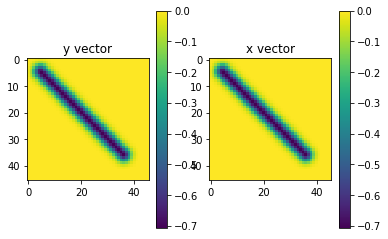

In [36]:
class LabelTransformer():
    def __init__(self):
        y_grid=tf.linspace(0.0,1.0,LABEL_HEIGHT)
        x_grid=tf.linspace(0.0,1.0,LABEL_WIDTH)
        yy,xx=tf.meshgrid(y_grid,x_grid,indexing='ij') #indexing is a must, otherwise, it's just bizzare!
        self.grid=tf.stack((yy,xx),axis=-1)
    
    def single_PAF(self, joint):
        """ Makes a single vector valued PAF (part affinity field) array
        *does not support batched input
        :return a tensor of shape (LABEL_HEIGHT, LABEL_WIDTH, 2)
        """  
        jpts = tf.reshape(joint[0:4], (2, 2))  # reshape to ((x1,y1),(x2,y2))
        if joint[4] == tf.constant(0.0):
            return tf.zeros((LABEL_HEIGHT, LABEL_WIDTH, 2), dtype=tf.float32)  # in case of empty joint
        else:
            # this follows the OpenPose paper of generating the PAFs
            vector_full = jpts[1] - jpts[0]  # get the joint vector
            vector_length = tf.linalg.norm(vector_full)  # get joint length
            vector_hat = vector_full / vector_length  # get joint unit vector
            normal_vector = tf.stack((-vector_hat[1], vector_hat[0]))
    
            vectors_from_begin = self.grid - jpts[0]  # get grid of vectors from first joint point
            vectors_from_end = self.grid - jpts[1]  # get grid of vectors from second joint point
            
            projections = tf.tensordot(vectors_from_begin, vector_hat, 1)  # get projection on the joint unit vector
            n_projections = tf.tensordot(vectors_from_begin, normal_vector, 1)  # get projection on the joint normal unit vector
            
            dist_from_begin=tf.linalg.norm(vectors_from_begin,axis=-1) #get distances from the begining, and end
            dist_from_end=tf.linalg.norm(vectors_from_end,axis=-1)
            
            begin_gaussian_mag=tf.exp((-(dist_from_begin ** 2) / PAF_GAUSSIAN_SIGMA_SQ)) #compute gaussian bells
            end_gaussian_mag=tf.exp((-(dist_from_end ** 2) / PAF_GAUSSIAN_SIGMA_SQ))
            normal_gaussian_mag=tf.exp((-(n_projections ** 2) / PAF_GAUSSIAN_SIGMA_SQ))
            
            limit = (0 <= projections) & (projections <= vector_length) #cutoff the joint before beginning and after end
            limit=tf.cast(limit,tf.float32)
            bounded_normal_gaussian_mag=normal_gaussian_mag*limit #bound the normal distance by the endpoints            
            
            max_magnitude=tf.math.reduce_max((begin_gaussian_mag,end_gaussian_mag,bounded_normal_gaussian_mag),axis=0)      
             
            vector_mag=tf.stack((max_magnitude, max_magnitude), axis=-1)
            
            result=vector_mag*vector_hat #broadcast joint direction vector to magnitude field           
            return result 

lt=LabelTransformer()

j1=tf.constant((0.8,0.8,0.1,0.1,2),dtype=tf.float32)
paf=lt.single_PAF(j1)
plt.subplot(1,2,1)
plt.imshow(paf[...,0])
plt.title("y vector")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(paf[...,1])
plt.title("x vector")
plt.colorbar()
